In [2]:
import pandas as pd

# Load CSV dataset
df = pd.read_csv(r'C:\Users\User\Desktop\dataverse_files/Climatology_Southern_Hemisphere.csv')

# Inspect dataset
print("Dataset Info:")
print(df.info())

# First few rows
print(df.head())

# Convert time column to datetime format
df['time'] = pd.to_datetime(df['time'])

# Confirm time conversion
print(df[['time']].head())

# Check how many unique polar lows (by ID)
unique_ids = df['ID'].nunique()
print(f"\nTotal Polar Low Events: {unique_ids}")

# Columns available
print("\nDataset Columns:")
print(df.columns)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377534 entries, 0 to 377533
Data columns (total 16 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              377534 non-null  int64  
 1   step                            377534 non-null  int64  
 2   lon                             377534 non-null  float64
 3   lat                             377534 non-null  float64
 4   time                            377534 non-null  object 
 5   PL_time_step                    377534 non-null  float64
 6   shear_cat                       377534 non-null  object 
 7   rel_vort_850_smth               377534 non-null  float64
 8   vortex_diameter                 377534 non-null  float64
 9   theta_trop_mean250              377534 non-null  float64
 10  theta_diff_500-sst_mean250      322299 non-null  float64
 11  shear_angle_925-500_mean250     377534 non-null  float64
 12  sh

In [3]:
from sklearn.model_selection import train_test_split

# Sort data by ID and Time
df = df.sort_values(by=['ID', 'time'])

# Create target variables (next step lat & lon)
df['lat_next'] = df.groupby('ID')['lat'].shift(-1)
df['lon_next'] = df.groupby('ID')['lon'].shift(-1)

# Drop rows without a next step
df.dropna(subset=['lat_next', 'lon_next'], inplace=True)

# Select features
features = [
    'lat', 'lon', 'rel_vort_850_smth', 'vortex_diameter', 'theta_trop_mean250',
    'theta_diff_500-sst_mean250', 'shear_angle_925-500_mean250',
    'shear_strength_925-500_mean250', 'slp', 'SST-T_500_mean250', 'land_dist'
]

# Encode categorical feature (shear_cat)
df = pd.get_dummies(df, columns=['shear_cat'], drop_first=True)

# Remove remaining missing values (small percentage)
df.dropna(inplace=True)

# Define features (X) and targets (y)
X = df[features + ['shear_cat_right']] if 'shear_cat_right' in df.columns else df[features]
y = df[['lat_next', 'lon_next']]

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (248139, 12), (248139, 2)
Testing set shape: (62035, 12), (62035, 2)


In [4]:
import pandas as pd
import numpy as np

# Assuming df is already loaded and time is converted:
df = df.sort_values(by=['ID', 'time'])

# Features for input sequence
features = [
    'lat', 'lon', 'rel_vort_850_smth', 'vortex_diameter',
    'theta_trop_mean250', 'theta_diff_500-sst_mean250', 
    'shear_angle_925-500_mean250', 'shear_strength_925-500_mean250', 
    'slp', 'SST-T_500_mean250', 'land_dist'
]

# Handling missing data
df = df.dropna(subset=features)

# Create sequences grouped by Polar Low IDs
grouped = df.groupby('ID')

# Build sequences (example: first 10 sequences)   
sequences = []
for _, group in grouped:
    seq_features = group[features].values
    sequences.append(seq_features)

# Check one sequence
print(f"Example sequence length: {len(sequences[0])}")
print(f"Example sequence shape (time_steps, features): {sequences[0].shape}")

Example sequence length: 13
Example sequence shape (time_steps, features): (13, 11)


In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler

# Compute incremental changes (target deltas)
df['delta_lat'] = df.groupby('ID')['lat'].diff().fillna(0)
df['delta_lon'] = df.groupby('ID')['lon'].diff().fillna(0)

# Create input/output sequences
X_sequences = []
y_sequences = []

for _, group in df.groupby('ID'):
    seq_X = group[features].values[:-1]  # all but last time step
    seq_y = group[['delta_lat', 'delta_lon']].values[1:]  # all but first (target deltas)
    if len(seq_X) > 0:
        X_sequences.append(seq_X)
        y_sequences.append(seq_y)

# Pad sequences
max_seq_len = max(len(s) for s in X_sequences)

X_padded = pad_sequences(X_sequences, maxlen=max_seq_len, padding='post', dtype='float32')
y_padded = pad_sequences(y_sequences, maxlen=max_seq_len, padding='post', dtype='float32')

# Scale inputs
num_samples, seq_len, num_features = X_padded.shape
scaler_X = StandardScaler()
X_flat = X_padded.reshape(-1, num_features)
X_scaled = scaler_X.fit_transform(X_flat).reshape(num_samples, seq_len, num_features)

# Scale outputs
scaler_y = StandardScaler()
y_flat = y_padded.reshape(-1, 2)
y_scaled = scaler_y.fit_transform(y_flat).reshape(num_samples, seq_len, 2)

print("Input shape:", X_scaled.shape)
print("Target shape:", y_scaled.shape)


Input shape: (13864, 117, 11)
Target shape: (13864, 117, 2)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Masking, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Build model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_seq_len, num_features)),

    GRU(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    GRU(96, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    GRU(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64),
    LeakyReLU(),
    Dropout(0.3),

    Dense(32),
    LeakyReLU(),

    Dense(2)  # Predict Δlat and Δlon
])

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model.summary()


c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 117, 11)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 117, 128)       │        54,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 117, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 117, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 117, 96)        │        65,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 117, 96)        │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 117, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 117, 64)        │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 117, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 117, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 117, 64)        │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 117, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 117, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 117, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 117, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 117, 2)         │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,794 (616.38 KB)

 Trainable params: 157,218 (614.13 KB)

 Non-trainable params: 576 (2.25 KB)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

history = model.fit(
    X_scaled, y_scaled,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop]
)



Epoch 1/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 84s 104ms/step - loss: 1.0820 - mae: 0.3202 - val_loss: 0.8721 - val_mae: 0.1740
Epoch 2/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 66s 95ms/step - loss: 0.9610 - mae: 0.2168 - val_loss: 0.8538 - val_mae: 0.1911
Epoch 3/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 69s 100ms/step - loss: 0.9448 - mae: 0.2036 - val_loss: 0.8147 - val_mae: 0.1713
Epoch 4/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 69s 99ms/step - loss: 0.8735 - mae: 0.1925 - val_loss: 0.7952 - val_mae: 0.1692
Epoch 5/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 67s 97ms/step - loss: 0.8369 - mae: 0.1809 - val_loss: 0.7770 - val_mae: 0.1751
Epoch 6/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 66s 95ms/step - loss: 0.8325 - mae: 0.1797 - val_loss: 0.7279 - val_mae: 0.1542
Epoch 7/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 67s 96ms/step - loss: 0.7845 - mae: 0.1721 - val_loss: 0.7413 - val_mae: 0.1491
Epoch 8/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 66s 95ms/step - loss: 0.7373 - mae: 0.1655 - val_loss: 0.7736 - val_mae: 0.1490
Epoch 9/50
694/694 ━━━━━━━━━━━━━━━━━━━

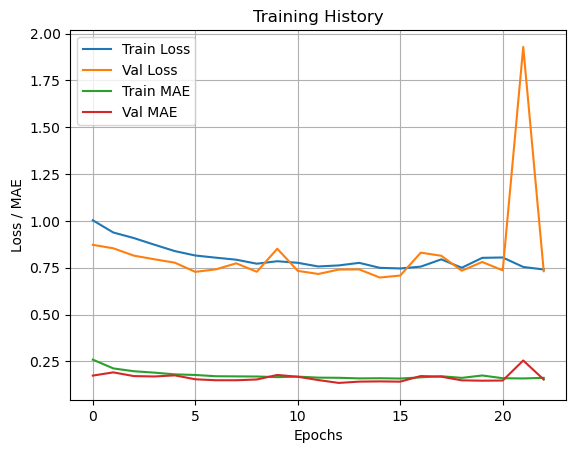

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title("Training History")
plt.xlabel("Epochs")
plt.ylabel("Loss / MAE")
plt.grid(True)
plt.show()

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Predict deltas
pred_scaled = model.predict(X_scaled)

# Inverse scale
pred_deltas = scaler_y.inverse_transform(pred_scaled.reshape(-1, 2)).reshape(X_scaled.shape[0], X_scaled.shape[1], 2)

# Reconstruct trajectory from deltas
seq_idx = 0
initial_lat = df[df['ID'] == df['ID'].unique()[seq_idx]]['lat'].iloc[0]
initial_lon = df[df['ID'] == df['ID'].unique()[seq_idx]]['lon'].iloc[0]

# Accumulate deltas to get predicted path
pred_traj_lat = np.cumsum(pred_deltas[seq_idx, :, 0]) + initial_lat
pred_traj_lon = np.cumsum(pred_deltas[seq_idx, :, 1]) + initial_lon

# Get actual trajectory
actual_group = df[df['ID'] == df['ID'].unique()[seq_idx]]
actual_lat = actual_group['lat'].values
actual_lon = actual_group['lon'].values




434/434 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step


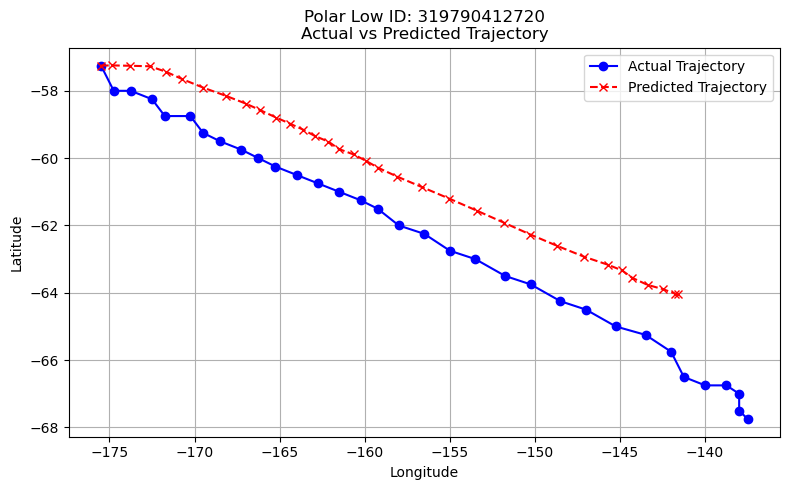

In [10]:
# Number of examples to visualize
num_to_plot = 31


polar_low_id = df['ID'].unique()[num_to_plot]

    # Actual trajectory
actual_group = df[df['ID'] == polar_low_id]
actual_lat = actual_group['lat'].values
actual_lon = actual_group['lon'].values

    # Initial point
initial_lat = actual_lat[0]
initial_lon = actual_lon[0]

    # Predicted deltas for this sequence
pred_seq = pred_deltas[num_to_plot][:len(actual_lat)]  # Match actual sequence length

    # Reconstruct predicted trajectory
pred_traj_lat = np.concatenate([[initial_lat], initial_lat + np.cumsum(pred_seq[:, 0])])
pred_traj_lon = np.concatenate([[initial_lon], initial_lon + np.cumsum(pred_seq[:, 1])])

    # Plotting
plt.figure(figsize=(8, 5))
plt.plot(actual_lon, actual_lat, 'bo-', label='Actual Trajectory')
plt.plot(pred_traj_lon, pred_traj_lat, 'rx--', label='Predicted Trajectory')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Polar Low ID: {polar_low_id}\nActual vs Predicted Trajectory')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
